# SRGAN

In [5]:
import os
import cv2
import numpy as np
from math import log2
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.utils.data
import torch.optim as optim

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
import torchvision.utils as vutils
from torchvision.models.vgg import vgg16

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("torch.device(cuda)")
    print("torch.cuda.device_count(): ", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name())
    print("torch.cuda.current_device()", torch.cuda.current_device())
else:
    device = torch.device("cpu")
    print("torch.device(cpu)")

torch.device(cuda)
torch.cuda.device_count():  4
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
torch.cuda.current_device() 0


# Creat dataset

In [9]:
transform = transforms.Compose(
    [
#      transforms.Resize(image_size),
#      transforms.CenterCrop(image_size),
     transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [20]:
batch_size = 1
data = ImageFolder("../Datasets/DCGAN_data/Cell5120/", transform=transform)
conf_data = ImageFolder("../Datasets/DCGAN_data/Cell5120/conf/", transform=transform)
sted_data = ImageFolder("../Datasets/DCGAN_data/Cell5120/sted/", transform=transform)

dataloader = DataLoader(data, batch_size, shuffle=True, num_workers=0)
conf_dataloader = DataLoader(conf_data, batch_size, shuffle=True, num_workers=0)
sted_dataloader = DataLoader(conf_data, batch_size, shuffle=True, num_workers=0)


print("len(datas): ",len(data))
print("len(dataloader): ", len(dataloader))
imgs, labels = iter(dataloader).next()
print("each batch's shape: ", imgs.shape)

len(datas):  8
len(dataloader):  8
each batch's shape:  torch.Size([1, 3, 5120, 5120])


tensor([0])


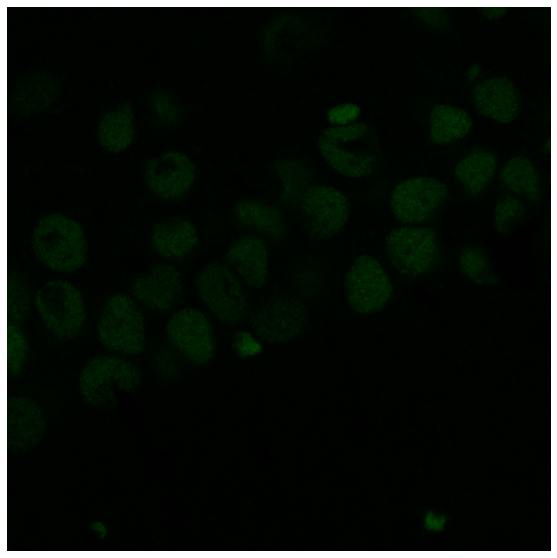

In [31]:
imgs, labels = iter(dataloader).next()
print(labels)
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(np.transpose(imgs[0,:,:,:],(2,1,0))*20)

torch.Size([3, 256, 256])
1.0 0.0


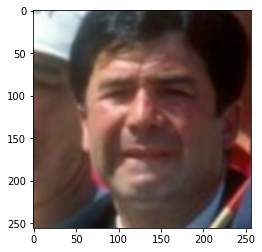

In [5]:
images_lr, images_hr = iter(train_loader).next()
image=images_hr[0]
print(image.size())
image_np=image.numpy()
print(image_np.max(),image_np.min())
image_np=np.transpose(image_np,(1,2,0))
plt.imshow(image_np)

torch.Size([3, 64, 64])
0.99607843 0.0


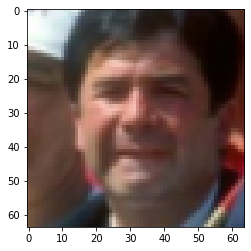

In [6]:
image=images_lr[0]
print(image.size())
image_np=image.numpy()
print(image_np.max(),image_np.min())
image_np=np.transpose(image_np,(1,2,0))
plt.imshow(image_np)

# Generator
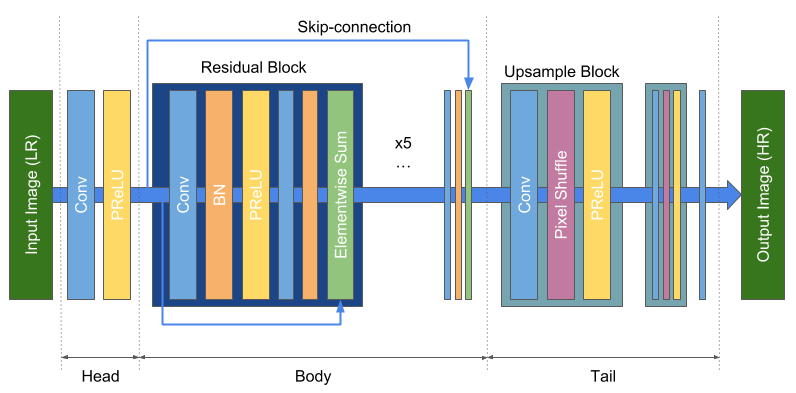

In [7]:
class Generator(nn.Module):
    def __init__(self,ngpu,image_size):
        super(Generator,self).__init__()
        self.ngpu = ngpu
        self.image_size=image_size
        
        self.pre_layer=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=9,stride=1,padding=4),
            nn.PReLU()
        )
        self.residual_layer=nn.Sequential(
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64)
        )
        self.middle_layer=nn.Sequential(
            nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64)
        )
        self.pixcelshuffer_layer=nn.Sequential(
            Pixcelshuffer(64,2),
            Pixcelshuffer(64,2),
            nn.Conv2d(64,3,kernel_size=9,stride=1,padding=4)
        )
    def forward(self,input_image):
        pre=self.pre_layer(input_image)
        res=self.residual_layer(pre)
        middle=self.middle_layer(res)
        middle=middle+pre
        output=self.pixcelshuffer_layer(middle)
        return output
    
    
class ResidualBlock(nn.Module):
    def __init__(self,input_channel):
        super(ResidualBlock,self).__init__()
        self.residualblock=nn.Sequential(
            nn.Conv2d(input_channel,input_channel,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(input_channel),
            nn.PReLU(),
            nn.Conv2d(input_channel,input_channel,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(input_channel)
        )
    def forward(self,x):
        residual=self.residualblock(x)
        return x+residual

class Pixcelshuffer(nn.Module):
    def __init__(self,input_channel,r): #r=upscale_factor
        super(Pixcelshuffer,self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(input_channel,256,kernel_size=3,stride=1,padding=1), 
            nn.PixelShuffle(r),
            nn.PReLU()
        )
    def forward(self,x):
        return self.layer(x)

In [19]:
ngpu = 2
image_size = 64
netG = Generator(ngpu,image_size).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu//2)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
# netG.apply(weights_init)
print("Create the generator")

Create the generator


In [20]:
test_input=torch.ones(1,3,64,64).to(device)
out=netG(test_input)
print(out.size())

torch.Size([1, 3, 256, 256])


# Discriminator
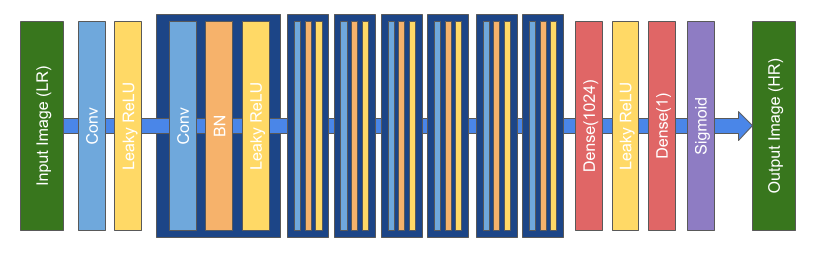

In [21]:
class Discriminator(nn.Module):
    def __init__(self,ngpu,patch_size):
        super(Discriminator,self).__init__()
        self.ngpu = ngpu
        self.conv_layers=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64,64,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128,128,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256,256,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(512,512,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2))#(512,16,16)
        
        self.dense_layer=nn.Sequential(
            nn.Linear(512*(patch_size//2** 4)**2,1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024,1),
            nn.Sigmoid())
        
    def forward(self,input_image):
        batch_size=input_image.size()[0]
        
        conv=self.conv_layers(input_image)
        reshape=conv.view(batch_size,-1)
        output=self.dense_layer(reshape)
        
        return output

In [22]:
patch_size=256
# Create the Discriminator
netD = Discriminator(ngpu,patch_size).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu//2)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
# netD.apply(weights_init)
print("Create the Discriminator")

Create the Discriminator


In [23]:
test_input=torch.ones(1,3,256,256).to(device)
out=netD(test_input)
print(out.size())

torch.Size([1, 1])


# loss & optimizer

In [24]:
from torchvision.models.vgg import vgg19

class GeneratorLoss(nn.Module):
    def __init__(self, loss_type='vgg22', adv_coefficient=1e-3):
        super(GeneratorLoss, self).__init__()
        self.content_loss = VGGLoss(loss_type)
        self.mse_loss = nn.MSELoss()
        self.adv_coefficient = adv_coefficient

    def forward(self, d_out_fake, real_img, fake_img):
        mse_loss = self.mse_loss(real_img, fake_img)
        content_loss = self.content_loss(real_img, fake_img)
        adv_loss = torch.mean(-torch.log(d_out_fake + 1e-3))
        return mse_loss + 2e-6*content_loss + self.adv_coefficient*adv_loss
    
class VGGLoss(nn.Module):
    def __init__(self, loss_type):
        super(VGGLoss, self).__init__()
        vgg = vgg19(pretrained=True)
        if loss_type == 'vgg22':
            vgg_net = nn.Sequential(*list(vgg.features[:9]))
        elif loss_type == 'vgg54':
            vgg_net = nn.Sequential(*list(vgg.features[:36]))
        
        for param in vgg_net.parameters():
            param.requires_grad = False

        self.vgg_net = vgg_net.eval()
        self.mse_loss = nn.MSELoss()

        self.register_buffer('vgg_mean', torch.tensor([0.485, 0.456, 0.406], requires_grad=False))
        self.register_buffer('vgg_std', torch.tensor([0.229, 0.224, 0.225], requires_grad=False))

    def forward(self, real_img, fake_img):
        real_img = real_img.sub(self.vgg_mean[:, None, None]).div(self.vgg_std[:, None, None])
        fake_img = fake_img.sub(self.vgg_mean[:, None, None]).div(self.vgg_std[:, None, None])
        feature_real = self.vgg_net(real_img)
        feature_fake = self.vgg_net(fake_img)
        return self.mse_loss(feature_real, feature_fake)

In [25]:
class DiscriminatorLoss(nn.Module):
    def __init__(self):
        super(DiscriminatorLoss, self).__init__()
        self.bce_loss = nn.BCELoss()

    def forward(self, d_out_real, d_out_fake):
        loss_real = self.bce_loss(d_out_real, torch.ones_like(d_out_real))
        loss_fake = self.bce_loss(d_out_fake, torch.zeros_like(d_out_fake))
        return loss_real + loss_fake

In [26]:
mse_loss = nn.MSELoss().to(device)
criterionG = GeneratorLoss().to(device)
criterionD = DiscriminatorLoss().to(device)

In [27]:
G_optimizer = optim.Adam(netG.parameters(), lr=1e-4)
D_optimizer = optim.Adam(netD.parameters(), lr=1e-4)

# Training

In [28]:
fixed_lr_hr = iter(train_loader).next()
fixed_lr = fixed_lr_hr[0].to(device)
fixed_hr = fixed_lr_hr[1].to(device)

[1/500][100/100]	Loss_D: 0.000002	Loss_G: 0.009929


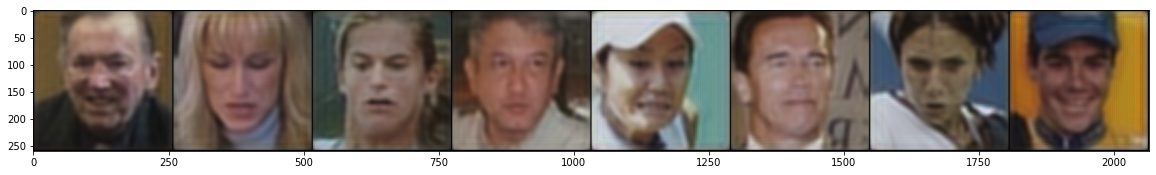

[2/500][100/100]	Loss_D: 0.000000	Loss_G: 0.009104


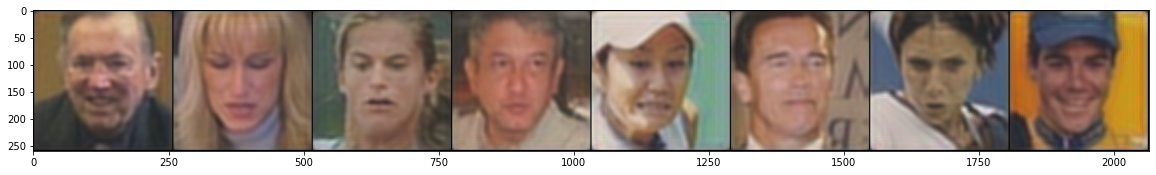

[3/500][100/100]	Loss_D: 0.000000	Loss_G: 0.009649


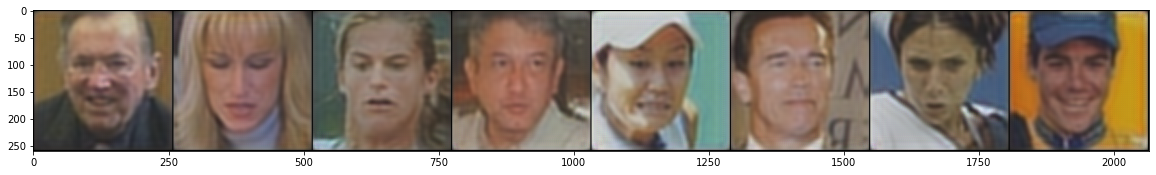

[4/500][100/100]	Loss_D: 0.000000	Loss_G: 0.009282


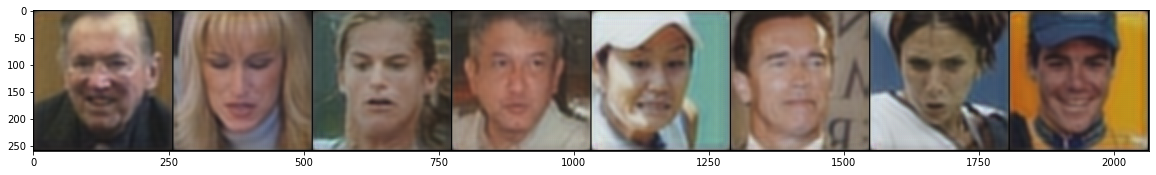

[5/500][100/100]	Loss_D: 0.344139	Loss_G: 0.007423


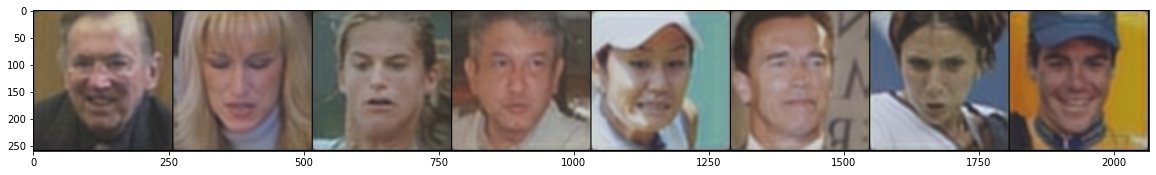

[6/500][100/100]	Loss_D: 1.981091	Loss_G: 0.006772


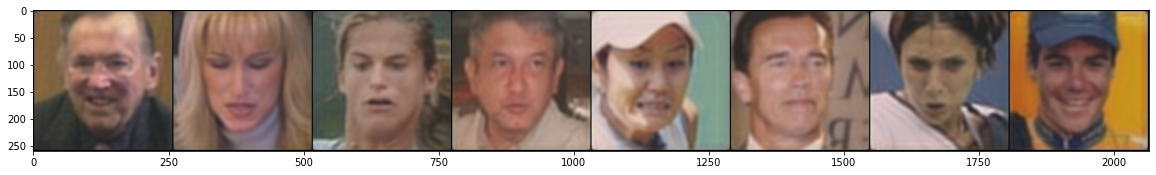

In [ ]:
num_epochs = 500
G_losses=[]
D_losses=[]
fake_img_list=[]

for epoch in range(1, num_epochs + 1):
    netG.train(), netD.train()
    for iteration, (input_img, real_img) in enumerate(train_loader, 1):
        input_img = input_img.to(device)
        real_img = real_img.to(device)
        fake_img = netG(input_img)
        ############################
        # (1) Update D network: maximize D(x)-1-D(G(z))
        ###########################
        D_optimizer.zero_grad()
        d_out_real = netD(real_img)
        d_out_fake = netD(fake_img)
        d_loss = criterionD(d_out_real, d_out_fake)
        d_loss.backward(retain_graph=True)
        D_optimizer.step()

        ############################
        # (2) Update G network: minimize 1-D(G(z)) + Perception Loss + Image Loss + TV Loss
        ###########################
        G_optimizer.zero_grad()
        g_loss = criterionG(d_out_fake.detach(), real_img, fake_img)
        g_loss.backward()
        G_optimizer.step()
        
    ############################
    # Log progress
    ###########################
    if epoch%1==0:
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())
        netG.eval()
        with torch.no_grad():
            fake = netG(fixed_lr).detach().cpu()
        fake_grid = cv2.rotate(np.transpose(vutils.make_grid(fake, padding=2, normalize=True).numpy()),cv2.ROTATE_90_CLOCKWISE)
        fake_img_list.append(fake_grid)

        print('[%d/%d][%d/%d]\tLoss_D: %f\tLoss_G: %f'
          %(epoch, num_epochs, iteration, len(train_loader), d_loss.item(), g_loss.item()))
        plt.figure(figsize=(20,20))
        plt.imshow(fake_grid)
        plt.show()

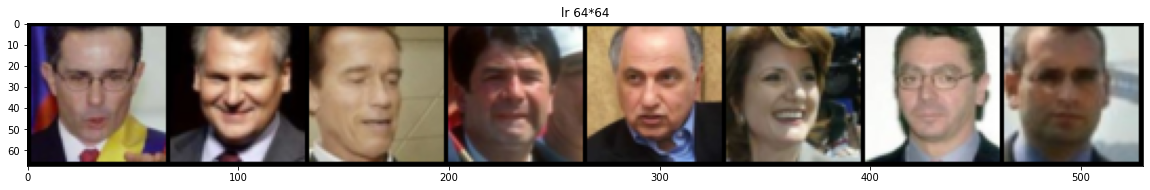

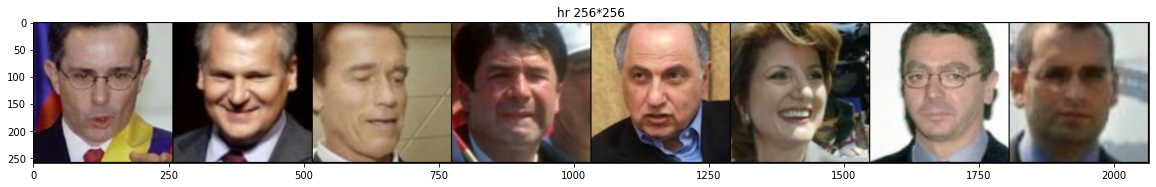

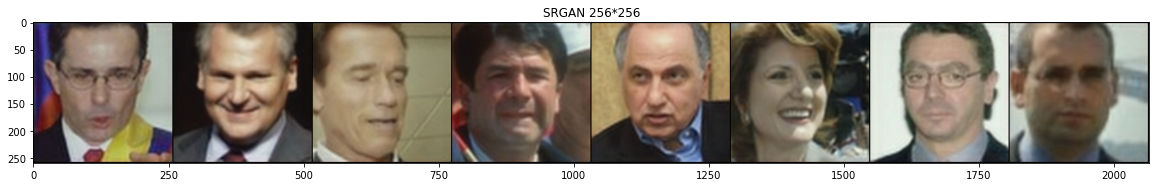

In [62]:
lr = fixed_lr.detach().cpu()
lr_grid = cv2.rotate(np.transpose(vutils.make_grid(lr, padding=2, normalize=True).numpy()),cv2.ROTATE_90_CLOCKWISE)
plt.figure(figsize=(20,20))
plt.title("lr 64*64")
plt.imshow(lr_grid)
plt.show()

hr = fixed_hr.detach().cpu()
hr_grid = cv2.rotate(np.transpose(vutils.make_grid(hr, padding=2, normalize=True).numpy()),cv2.ROTATE_90_CLOCKWISE)
plt.figure(figsize=(20,20))
plt.title("hr 256*256")
plt.imshow(hr_grid)
plt.show()

fake = netG(fixed_lr).detach().cpu()
fake_grid = cv2.rotate(np.transpose(vutils.make_grid(fake, padding=2, normalize=True).numpy()),cv2.ROTATE_90_CLOCKWISE)
plt.figure(figsize=(20,20))
plt.title("SRGAN 256*256")
plt.imshow(fake_grid)
plt.show()

In [60]:
netD(netG(fixed_lr))

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0', grad_fn=<SigmoidBackward0>)